# Pytorch RNN Classifier

This will follow along the tutorial [here](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) to build a model to classify names using a simple recursive neural network.

## 1. Prerequesites

Check if GPU is available to Torch:

In [4]:
import torch

# Is PyTorch capable of use NVidia card?
if torch.cuda.is_available():
    print("Yes, you have CUDA available.")
    device = torch.device('cuda')
else:
    print("Only CPU is available.")
    device = torch.device('cpu')

Only CPU is available.


Import relevant libraries:

In [5]:
from pathlib import Path

from torch import nn
from torch.utils.data import DataLoader # Iterable of samples
from torchvision import datasets # Object to access dataset
from torchvision.transforms import ToTensor

Download the dataset:

In [6]:
!wget -nc https://download.pytorch.org/tutorial/data.zip
!unzip -n data.zip

--2025-03-26 15:48:55--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 108.139.29.73, 108.139.29.95, 108.139.29.54, ...
Connecting to download.pytorch.org (download.pytorch.org)|108.139.29.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.06s   

2025-03-26 15:48:55 (44.0 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/It

Convert unicode data to plain ASCII. Simplification in characters allow for a much smaller token representation and help for a better classification with much less training data.

In [7]:
import string
import unicodedata

allowed_characters = string.ascii_letters + " .,;'"

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s): # Only works for latin alphabets
    return ''.join(
        c for c in unicodedata.normalize('NFKD', s) # Compatibility (with other characters) decomposition (breakdown char to its decomposed form)

        if unicodedata.category(c) != 'Mn' # non-spacing mark
        and c in allowed_characters
    )

# Example of conversion (simplified chinese)
print (f"converting '你好世界！' to {unicodeToAscii('你好世界！')}")

# Working example
print (f"converting 'Ślusàrski' to {unicodeToAscii('Ślusàrski')}")

converting '你好世界！' to 
converting 'Ślusàrski' to Slusarski


Define functions to one-hot encoding letters.

In [8]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return allowed_characters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, len(allowed_characters))
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

# Example
for x in ['a', 'B', 'z' ,'1', '/']:
    print(f"Char \"{x}\" is in position ({letterToIndex(x)})")

# One-Hot encoding example
print(f"Tensor shape of encoded sentence \"Hello\": {list(lineToTensor('Hello').shape)}")

Char "a" is in position (0)
Char "B" is in position (27)
Char "z" is in position (25)
Char "1" is in position (-1)
Char "/" is in position (-1)
Tensor shape of encoded sentence "Hello": [5, 1, 57]


## 2. Data loading

In order to use our data, we will use [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) type classes as an interface to interact with out data.

In [9]:
from io import open
import glob
import os
import time

import torch
from torch.utils.data import Dataset

class NamesDataset(Dataset):

    def __init__(self, data_dir):
        self.data_dir = data_dir # for provenance of the dataset
        self.load_time = time.localtime # for provenance of the dataset
        labels_set = set() #set of all classes

        self.data = []
        self.data_tensors = []
        self.labels = []
        self.labels_tensors = []

        #read all the ``.txt`` files in the specified directory
        text_files = glob.glob(os.path.join(data_dir, '*.txt'))
        for filename in text_files:
            label = os.path.splitext(os.path.basename(filename))[0] # 'Arabic.txt' -> ['Arabic', '.txt']
            labels_set.add(label)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            for name in lines:
                self.data.append(name) # Save input name as is
                self.data_tensors.append(lineToTensor(name)) # Save input name as one-hot encoded tensor
                self.labels.append(label) # Save file name as label

        #Cache the tensor representation of the labels
        self.labels_uniq = list(labels_set) # Parse label set into a list of unique elements
        for idx in range(len(self.labels)):
            temp_tensor = torch.tensor([self.labels_uniq.index(self.labels[idx])], dtype=torch.long)
            self.labels_tensors.append(temp_tensor)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_item = self.data[idx]
        data_label = self.labels[idx]
        data_tensor = self.data_tensors[idx]
        label_tensor = self.labels_tensors[idx]

        return label_tensor, data_tensor, data_label, data_item

In [10]:
alldata = NamesDataset("data/names")
print(f"loaded {len(alldata)} items of data")
print(f"example = {alldata[0]}")

loaded 20074 items of data
example = (tensor([7]), tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

As seen in the figure below, the frequency of each label is consderably different. There's a disproportionate amount of russian names than any other language. Also, asian names have a very low frequency. This may impact the results as the model will tend towards the more frequent data labels.

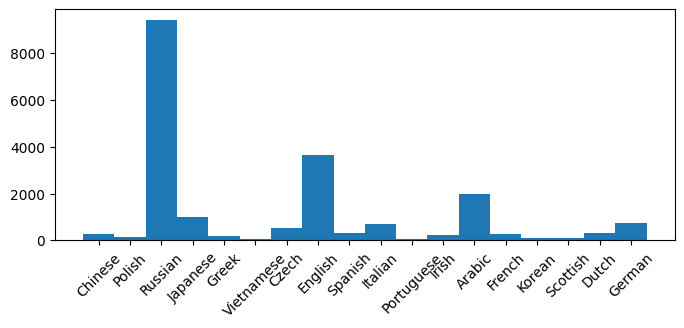

In [11]:
import matplotlib.pyplot as plt

x,cc = torch.tensor(alldata.labels_tensors).unique(return_counts = True)

px = 1/plt.rcParams['figure.dpi']  # pixel in inches
fig, ax = plt.subplots(figsize = (px*800, px*300))
ax.bar(x, cc, width = 1, edgecolor = "black", linewidth = 0)

ax.set_xticks(x, labels = [alldata.labels_uniq[i] for i in x], rotation = 45)
plt.show()

We will use [random_split](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split) to split our data. In order to give a reproducible train and test sets, we will specify the generator object to use to split the data. The seed is the only element required to lock the split.

In [12]:
train_set, test_set = torch.utils.data.random_split( # Split data in 85/15
    alldata,
     [.85, .15],
    generator = torch.Generator(device=device).manual_seed(2024) #
    )

print(f"train examples = {len(train_set)}, validation examples = {len(test_set)}")

train examples = 17063, validation examples = 3011


## 3. Model definition

We will now create our model using a class. For this classification model we will be using a RNN which accepts a sequence as input and reiterates model parameters to compute the output for each iteration making use of a hidden layer, an additional input on each iteration which carries information of previous elements of the sequence to the actual element in question.

In this particular model, we will be using the last state of the hidden layer (the actual output layer of the RNN in our model) to get the probability for each class.

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNN, self).__init__()

        self.rnn = nn.RNN(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        rnn_out, hidden = self.rnn(line_tensor)
        output = self.h2o(hidden[0]) # We take the output from the hidden layer
        output = self.softmax(output)

        return output

In [14]:
# Model dimensions
rnn = CharRNN(
      input_size = len(allowed_characters),
      hidden_size = 158,
      output_size = len(alldata.labels_uniq))

We define a function to extract the label from the `LogSoftmax` output of the last layer of the model.

In [15]:
def label_from_output(output, output_labels):
    top_n, top_i = output.topk(1)
    label_i = top_i[0].item()
    return output_labels[label_i], label_i

input = lineToTensor('Albert')
output = rnn(input) # This is equivalent to ``output = rnn.forward(input)``
print(output)
print(label_from_output(output, alldata.labels_uniq))

tensor([[-2.9869, -2.8381, -2.8635, -2.8718, -2.8597, -2.8588, -2.7963, -2.8942,
         -2.8673, -2.9959, -3.0257, -2.8535, -2.8924, -2.8244, -2.8211, -2.8954,
         -2.9964, -2.9231]], grad_fn=<LogSoftmaxBackward0>)
('Czech', 6)


## 4. Model training

We now define a generic function to train our model in mini-batches.

In [16]:
import random
import numpy as np

def train(rnn, training_data, n_epoch = 10, n_batch_size = 64, report_every = 50, learning_rate = 0.2, criterion = nn.NLLLoss()):
    """
    Learn on a batch of training_data for a specified number of iterations and reporting thresholds
    """
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []
    rnn.train()
    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

    start = time.time()
    print(f"training on data set with n = {len(training_data)}")

    for iter in range(1, n_epoch + 1):
        rnn.zero_grad() # clear the gradients

        # create some minibatches
        # we cannot use dataloaders because each of our names is a different length
        batches = list(range(len(training_data)))
        random.shuffle(batches)
        batches = np.array_split(batches, len(batches) //n_batch_size )

        for idx, batch in enumerate(batches):
            batch_loss = 0
            # Iterate over each element of batch to train and add total batch loss
            for i in batch: #for each example in this batch
                (label_tensor, text_tensor, label, text) = training_data[i]
                output = rnn.forward(text_tensor)
                loss = criterion(output, label_tensor)
                batch_loss += loss

            # optimize parameters
            batch_loss.backward()
            nn.utils.clip_grad_norm_(rnn.parameters(), 3) # Avoid exploding gradient
            optimizer.step() # Update parameters
            optimizer.zero_grad() # Set loss function gradient values back to 0

            current_loss += batch_loss.item() / len(batch) # Update mean loss value for batch

        all_losses.append(current_loss / len(batches) )
        if iter % report_every == 0:
            print(f"{iter} ({iter / n_epoch:.0%}): \t average batch loss = {all_losses[-1]}")
        current_loss = 0

    return all_losses


In [17]:
mfile = Path("rnn-01.bin")
if mfile.exists():
  rnn = torch.load(mfile)
else:
  start = time.time()
  all_losses = train(rnn, train_set, n_epoch=27, learning_rate=0.15, report_every=5)
  end = time.time()
  print(f"training took {end-start}s")

training on data set with n = 17063
5 (19%): 	 average batch loss = 0.8954794301281367
10 (37%): 	 average batch loss = 0.7184265073028998
15 (56%): 	 average batch loss = 0.5918119772432717
20 (74%): 	 average batch loss = 0.4998090745069996
25 (93%): 	 average batch loss = 0.42063938335506407
training took 601.2007739543915s


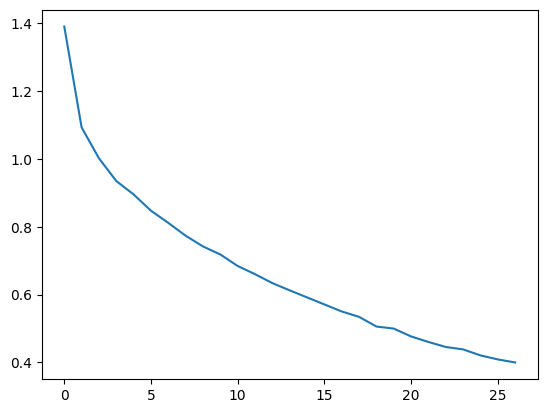

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

## 5. Evaluation

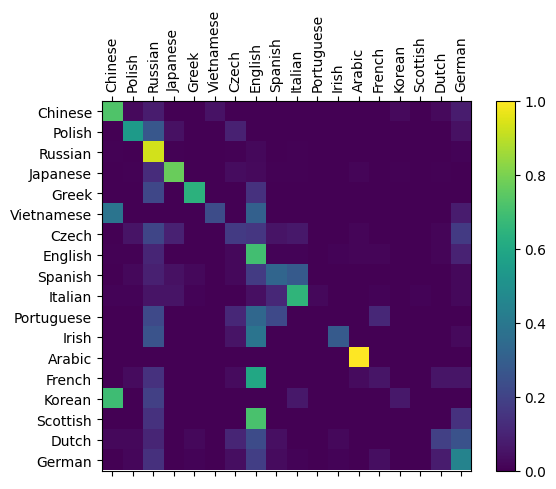

In [19]:
def evaluate(rnn, testing_data, classes):
    confusion = torch.zeros(len(classes), len(classes))

    rnn.eval() #set to eval mode
    with torch.no_grad(): # do not record the gradients during eval phase
        for i in range(len(testing_data)):
            (label_tensor, text_tensor, label, text) = testing_data[i]
            output = rnn(text_tensor)
            guess, guess_i = label_from_output(output, classes)
            label_i = classes.index(label)
            confusion[label_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(len(classes)):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy()) #numpy uses cpu here so we need to use a cpu version
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
    ax.set_yticks(np.arange(len(classes)), labels=classes)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()



evaluate(rnn, test_set, classes=alldata.labels_uniq)

From this, we can extract some information regarding the efectiveness of the model.

First, we can observe highest scores on the diagonal, i.e. most predictions are correctly being classified.

Second, in the case of Irish, French and Scotish names are wrongly classified as English. This comes from the fact that these subsets are relatively small with respect to others and also similarities between the names since France and Great Britain share commonalities in language but also Scotland and Ireland specially since both are English speaking countries.

Lastly, the model doesn't work well with east asian countries. We notice Vietnamese and Korean names classified mostly as Chinese for similar reasons explained in the case with English, Scotish, Irish and French names.


The dataset is small (only 20,074 data points) and the simplicity of the model are limiting reasons for the effectiveness of the model. Small variations within names of similar speaking languages are not picked by the model, and as such it would require a more robust algorithm.